In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="white", color_codes=True)


iris = datasets.load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target)

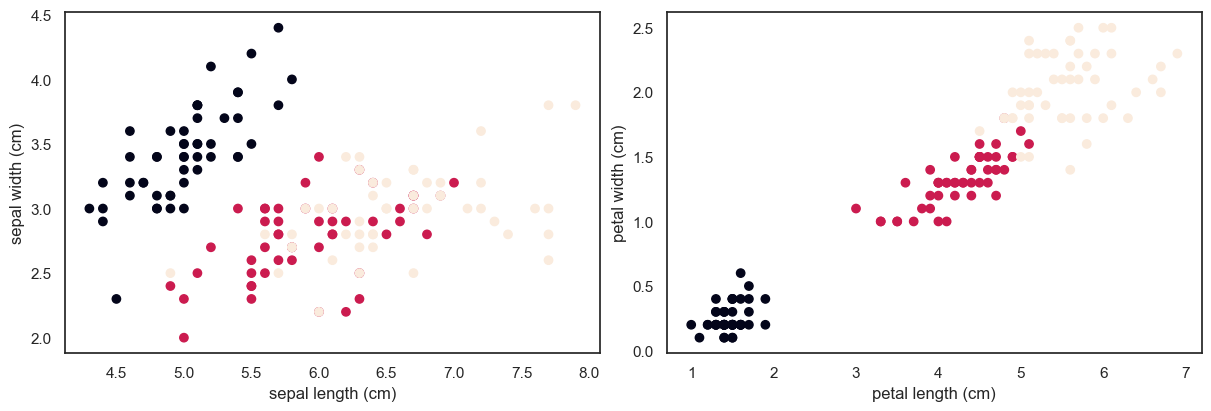

In [2]:
fig, ax = plt.subplots(1, 2, constrained_layout = True)
fig.set_figheight(4)
fig.set_figwidth(12)

ax[0].scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

ax[1].scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target)
ax[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])

plt.show()

In [3]:
class KNN:
    def __init__(self, k):        
        self.k = k
    
    def fit(self, x, y):
        self.train_X = x
        self.train_y = y
        
    def predict(self, x):
        dists = self.compute_distances(x)        
        pred = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            indices = dists[i].argsort()[:self.k]
            pred[i] = np.argmax(np.bincount(self.train_y[indices]))
        return pred
        
    def compute_distances(self, x):
        num_test = x.shape[0]
        num_train = self.train_X.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sum(np.abs(x[:,None,:] - self.train_X[None,:,:]),axis=2)
        return dists

In [4]:
knn = KNN(5)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

In [5]:
f = np.sum([1 if pred[i] != y_test[i] else 0 for i in range(x_test.shape[0])])
print(1 - f/x_test.shape[0])

0.9736842105263158


## Метод потенциальных функций
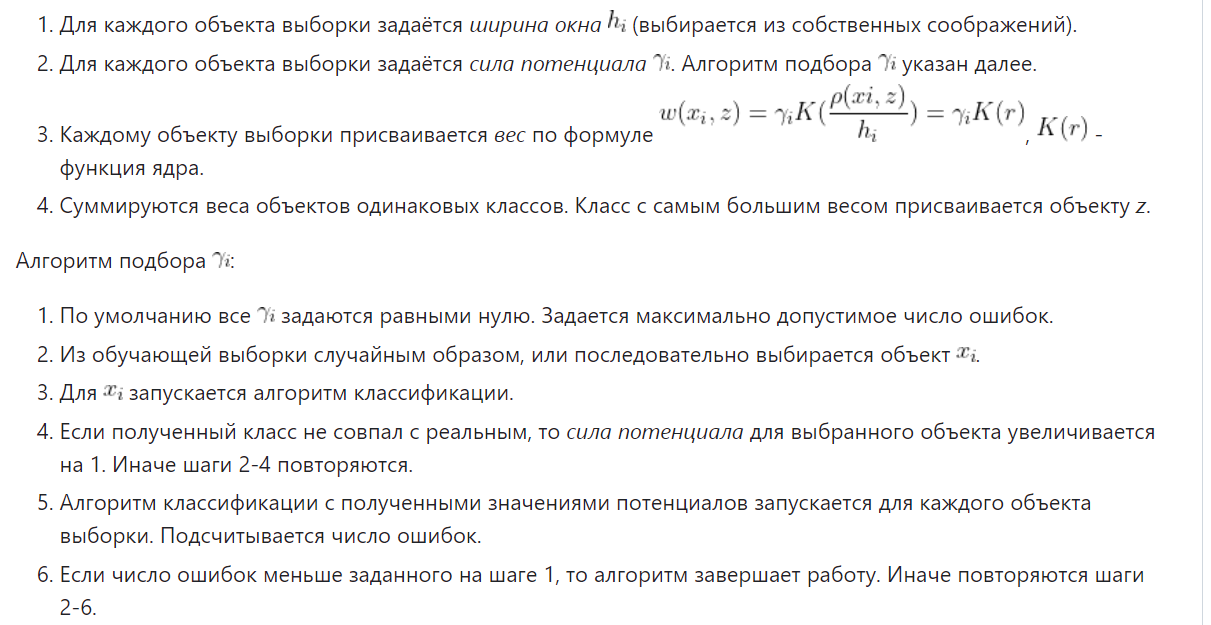

In [ ]:
def epachechnikov(x):    
    return 3/4 * (1 - x**2) * np.where(np.abs(x) <= 1, 1, 0)

def quartic(x):
    return 15/16 * (1 - x**2) * np.where(np.abs(x) <= 1, 1, 0)

def triangle(x):
    return (1 - np.abs(x)) * np.where(np.abs(x) <= 1, 1, 0)

def gaussian(x):
    return 1/(np.sqrt(2 * np.pi)) * np.exp(-1 * x**2/2)

def rectangle(x):
    return 1/2 * np.where(np.abs(x) <= 1, 1, 0)

class PFM:
    
    def __init__(self, h, max_err_num, kernel=epachechnikov):
        
        self.h = h
        self.max_err_num = max_err_num  
        self.k = kernel
    
    def fit(self, x, y):
        
        self.train_X = x
        self.train_y = y              
        self.gamma = np.zeros(self.train_X.shape[0])        
        err_num = self.max_err_num        
        
        while (err_num >= self.max_err_num):
            for i in range(self.train_X.shape[0]):                
                if (self.predict(self.train_X[i]) != self.train_y[i]):
                    self.gamma[i] += 1            
            err_num = np.sum([1 if (self.predict(self.train_X[i]) != self.train_y[i]) else 0
                              for i in range(self.train_X.shape[0])])
        
        self.zero_potentials_idxs = np.array([i for i in range(self.train_X.shape[0]) if self.gamma[i] == 0])
        self.nonzero_potentials_idxs = np.array([i for i in range(self.train_X.shape[0]) if self.gamma[i] != 0])        
    
    def calculate_weights(self, z):
        weights = [self.gamma[j] * self.k(np.sqrt(np.sum((self.train_X[j] - z)**2))/self.h)
                       for j in range(self.train_X.shape[0])]
        fcw = np.sum([weights[j] if (self.train_y[j] == 0) else 0 for j in range(self.train_X.shape[0])])
        scw = np.sum([weights[j] if (self.train_y[j] == 1) else 0 for j in range(self.train_X.shape[0])])
        tcw = np.sum([weights[j] if (self.train_y[j] == 2) else 0 for j in range(self.train_X.shape[0])])
        return fcw, scw, tcw
    
    def predict(self, z: np.array):
        
        if (len(z.shape) > 1):
            pred = np.zeros((z.shape[0]))        
            for i in range(z.shape[0]):
                fcw, scw, tcw = self.calculate_weights(z[i]) 
                pred[i] = max(dict(enumerate([fcw, scw, tcw], 0)).items(), key=lambda k:k[1])[0]        
        else:
            fcw, scw, tcw = self.calculate_weights(z)
            pred = max(dict(enumerate([fcw, scw, tcw], 0)).items(), key=lambda k:k[1])[0]        
        return pred

In [7]:
pfm = PFM(4.0, 1, kernel=triangle)
pfm.fit(x_train, y_train)
pred = pfm.predict(x_test)
f = np.sum([1 if pred[i] != y_test[i] else 0 for i in range(x_test.shape[0])])
print(1 - f/x_test.shape[0])

0.9736842105263158


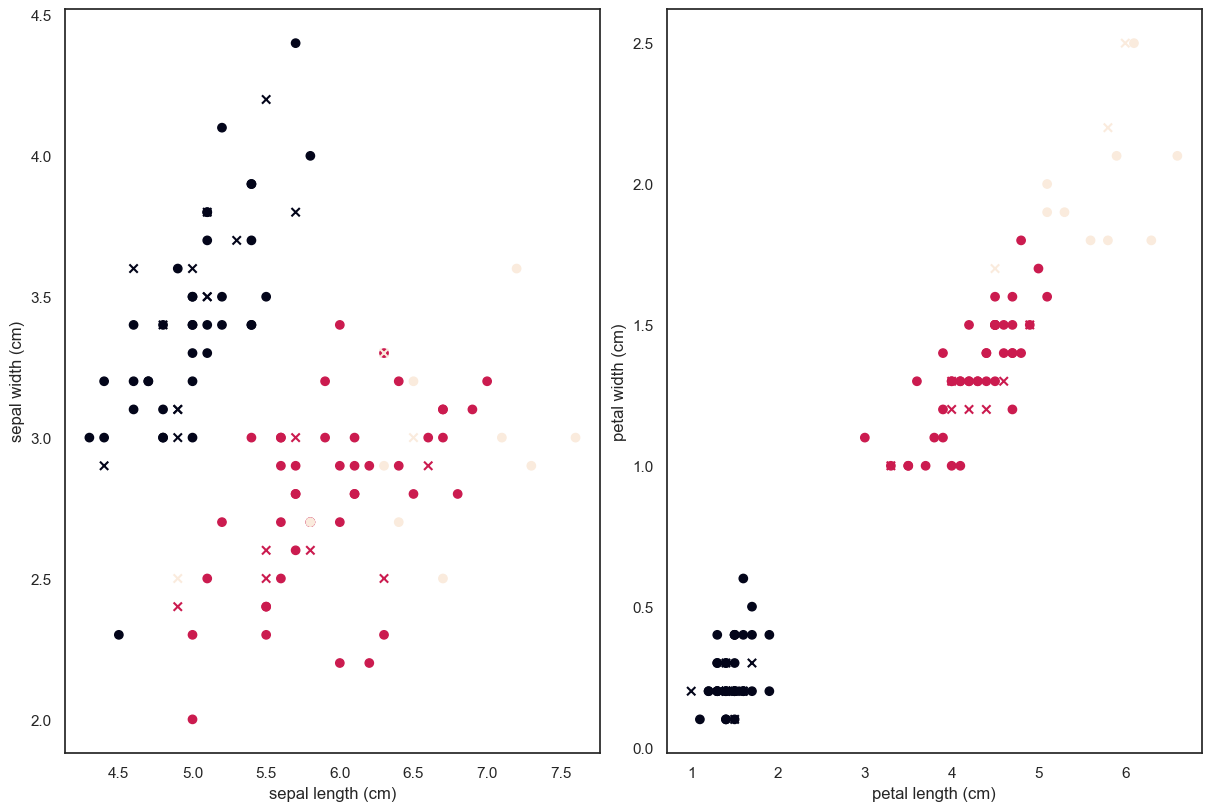

In [8]:
fig, ax = plt.subplots(1, 2, constrained_layout = True)
fig.set_figheight(8)
fig.set_figwidth(12)

ax[0].scatter(iris.data[pfm.zero_potentials_idxs, 0], iris.data[pfm.zero_potentials_idxs, 1],
              c=iris.target[pfm.zero_potentials_idxs])
ax[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
ax[0].scatter(iris.data[pfm.nonzero_potentials_idxs, 0], iris.data[pfm.nonzero_potentials_idxs, 1],
              c=iris.target[pfm.nonzero_potentials_idxs], marker='x')

ax[1].scatter(iris.data[pfm.zero_potentials_idxs, 2], iris.data[pfm.zero_potentials_idxs, 3], 
              c=iris.target[pfm.zero_potentials_idxs])
ax[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])
ax[1].scatter(iris.data[pfm.nonzero_potentials_idxs, 2], iris.data[pfm.nonzero_potentials_idxs, 3], 
              c=iris.target[pfm.nonzero_potentials_idxs], marker='x')

plt.show()

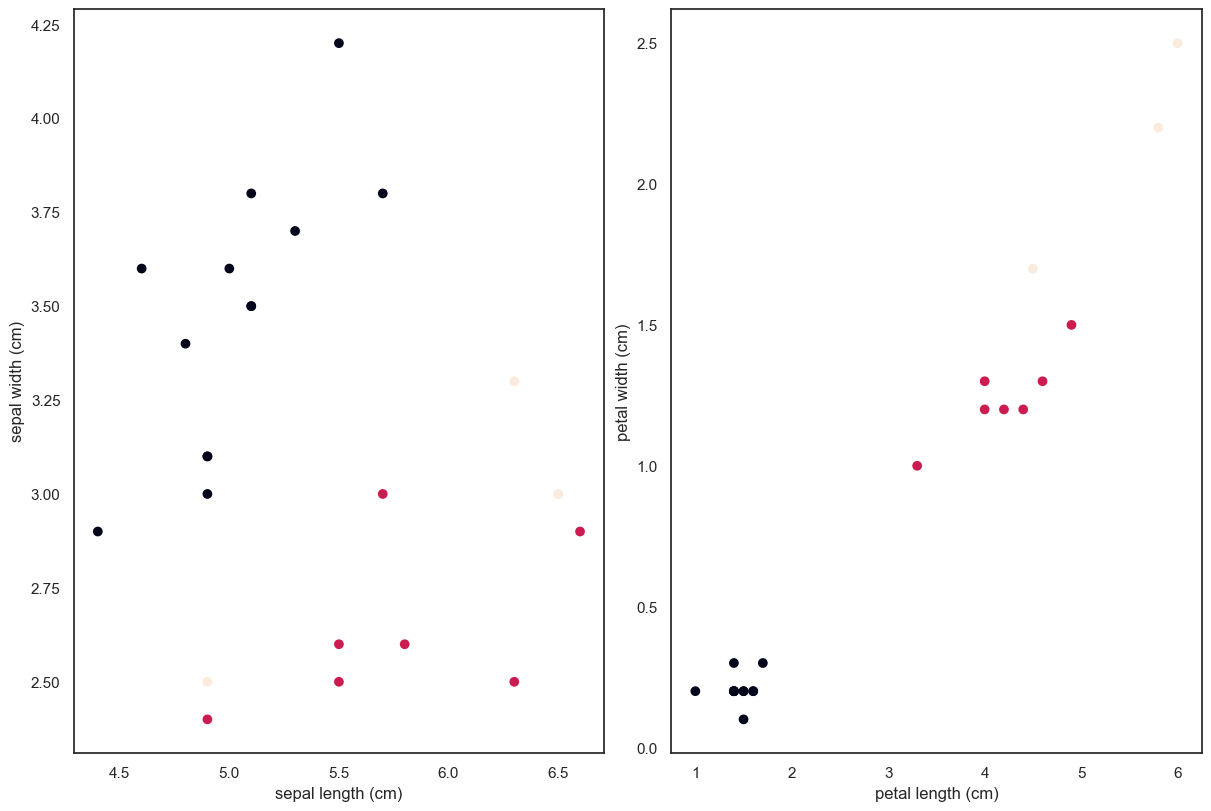

In [9]:
fig, ax = plt.subplots(1, 2, constrained_layout = True)
fig.set_figheight(8)
fig.set_figwidth(12)

ax[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
ax[0].scatter(iris.data[pfm.nonzero_potentials_idxs, 0], iris.data[pfm.nonzero_potentials_idxs, 1],
              c=iris.target[pfm.nonzero_potentials_idxs])

ax[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])
ax[1].scatter(iris.data[pfm.nonzero_potentials_idxs, 2], iris.data[pfm.nonzero_potentials_idxs, 3], 
              c=iris.target[pfm.nonzero_potentials_idxs])

plt.show()